# Setting

In [ ]:
import os
# apply offline index
os.environ["PIP_NO_INDEX"] = "1"

WHEELS = "/kaggle/input/proj2-pip-dependency"

# pip local install
!pip install --no-index --find-links {WHEELS} sentence-transformers transformers peft accelerate datasets

In [ ]:
# dataset setting
train_path = '/kaggle/input/llm-classification-finetuning/train.csv'
test_path = '/kaggle/input/llm-classification-finetuning/test.csv'

import pandas as pd
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train dataset size:", train_df.shape)
print("Test dataset size:", test_df.shape)

In [ ]:
SEED = 42

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Step 1. Baseline Model

In [ ]:
# imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [ ]:
# copy dataframe
step1_train_df = train_df.copy()
step1_test_df = test_df.copy()

# create target variable 'y'
target_cols = ['winner_model_a', 'winner_model_b', 'winner_tie']
y_one_hot = step1_train_df[target_cols].values
y = np.argmax(y_one_hot, axis=1)

In [ ]:
# extract lexical/length features
def extract_length_features(df):
    features = pd.DataFrame()
    # 1. prompt length
    features['prompt_len'] = df['prompt'].apply(len)

    # 2. response_a/b length
    features['response_a_len'] = df['response_a'].apply(len)
    features['response_b_len'] = df['response_b'].apply(len)

    # 3. difference and ratio between response_a/b
    features['response_diff_len'] = features['response_a_len'] - features['response_b_len']
    features['response_ratio_len'] = features['response_a_len'] / (features['response_b_len'] + 1e-6) # prevent divided by zero

    return features

In [ ]:
# Extract features for training and testing datasets
X_train_features = extract_length_features(step1_train_df)
X_test_features = extract_length_features(step1_test_df)

# Convert features to numpy array for easier indexing
X = X_train_features.values
X_test = X_test_features.values
y_array = y

# Create train data result array
oof_preds_train = np.zeros((X.shape[0], len(target_cols)))
# Create test data result array (final result)
oof_predictions_test = np.zeros((X_test.shape[0], len(target_cols)))

# K-Fold loop
for fold, (train_index, val_index) in enumerate(skf.split(X, y_array)):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_array[train_index], y_array[val_index]

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(
        random_state=SEED,
        max_iter=1000
    )

    # Train the model
    model.fit(X_train, y_train)

    # save train data result
    val_predictions = model.predict_proba(X_val)
    oof_preds_train[val_index] = val_predictions

    # save test data result
    test_fold_predictions = model.predict_proba(X_test)
    oof_predictions_test += test_fold_predictions

overall_logloss = log_loss(y_array, oof_preds_train, labels=range(len(target_cols)))

print(f"Overall OOF Log Loss: {overall_logloss:.6f}")

# Save the average of test data result array
predictions = oof_predictions_test / skf.n_splits

Overall OOF Log Loss: 1.072488


In [ ]:
# Create the submission DataFrame
sub_step1 = pd.DataFrame({
    'id': step1_test_df['id'],
    'winner_model_a': predictions[:, 0], # Probability for model_a
    'winner_model_b': predictions[:, 1], # Probability for model_b
    'winner_tie': predictions[:, 2]      # Probability for tie
})

# Save the submission file
sub_step1.to_csv('step_1_submission.csv', index=False)

print("'step_1_submission.csv' file created successfully.")
print(sub_step1.head())

✅ 'step_1_submission.csv' file created successfully.
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.325499        0.340385    0.334116
1   211333        0.436679        0.247327    0.315994
2  1233961        0.398031        0.327290    0.274678


# Step 2. Embedding-based Model

In [ ]:
# imports

# !pip install -q sentence-transformers

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

In [ ]:
# copy dataframe
step2_train_df = train_df.copy()
step2_test_df = test_df.copy()

# create target variable 'y_train_labels'
target_cols = ['winner_model_a', 'winner_model_b', 'winner_tie']
y_one_hot = step2_train_df[target_cols].values
y_train_labels = np.argmax(y_one_hot, axis=1)

In [ ]:
# 1. Load the pre-trained Sentence Embedding Model (by kaggle dataset)
MiniLM_dir = '/kaggle/input/sentencetransformersallminilml6v2'
embedding_model = SentenceTransformer(MiniLM_dir)

# 2. Construct the combined prompt+response texts
# Create 4 data points for each sample: A and B as winner, and A and B as loser/tie
# The core idea is to encode the relationship between prompt and response.
train_texts_A = step2_train_df['prompt'] + ' [SEP] ' + step2_train_df['response_a']
train_texts_B = step2_train_df['prompt'] + ' [SEP] ' + step2_train_df['response_b']

test_texts_A = step2_test_df['prompt'] + ' [SEP] ' + step2_test_df['response_a']
test_texts_B = step2_test_df['prompt'] + ' [SEP] ' + step2_test_df['response_b']

print(f"Loaded embedding model: {MiniLM_dir}. Embedding dimension will be {embedding_model.get_sentence_embedding_dimension()}")

Loaded embedding model: all-MiniLM-L6-v2. Embedding dimension will be 384


In [ ]:
# 3. Extract embeddings
# Convert texts to dense vector embeddings
print("Starting to compute embeddings for training data...")
train_emb_A = embedding_model.encode(train_texts_A.tolist(), convert_to_numpy=True, show_progress_bar=True, batch_size=512)
train_emb_B = embedding_model.encode(train_texts_B.tolist(), convert_to_numpy=True, show_progress_bar=True, batch_size=512)

print("Starting to compute embeddings for test data...")
test_emb_A = embedding_model.encode(test_texts_A.tolist(), convert_to_numpy=True, show_progress_bar=True, batch_size=512)
test_emb_B = embedding_model.encode(test_texts_B.tolist(), convert_to_numpy=True, show_progress_bar=True, batch_size=512)

# 4. Construct the final features for the classifier
# The feature vector is typically the concatenation of Emb_A, Emb_B, and their difference.
# The difference vector captures which response is "better" relative to the other.
X_train_embeddings = np.concatenate([train_emb_A, train_emb_B, np.abs(train_emb_A - train_emb_B)], axis=1)
X_test_embeddings = np.concatenate([test_emb_A, test_emb_B, np.abs(test_emb_A - test_emb_B)], axis=1)

print(f"Final training feature shape: {X_train_embeddings.shape}")

Starting to compute embeddings for training data...


Batches:   0%|          | 0/113 [00:00<?, ?it/s]

Batches:   0%|          | 0/113 [00:00<?, ?it/s]

Starting to compute embeddings for test data...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Final training feature shape: (57477, 1152)


In [ ]:
# OOF (out-of-fold) predictions for CV logloss, and averaged test predictions
oof = np.zeros((len(step2_train_df), 3), dtype=np.float64)
test_pred = np.zeros((len(step2_test_df), 3), dtype=np.float64)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_embeddings, y_train_labels), 1):
    # 1) Scale inside each fold to avoid data leakage
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_train_embeddings[tr_idx])
    X_va = scaler.transform(X_train_embeddings[va_idx])
    X_te = scaler.transform(X_test_embeddings)

    # 2) Train classifier on this fold
    clf = LogisticRegression(
        random_state=SEED,
        max_iter=1000
    )
    clf.fit(X_tr, y_train_labels[tr_idx])

    # 3) Collect OOF and test predictions
    oof[va_idx] = clf.predict_proba(X_va)
    test_pred += clf.predict_proba(X_te) / skf.n_splits

    # 4) Fold logloss
    fold_ll = log_loss(y_train_labels[va_idx], oof[va_idx])
    print(f"[Fold {fold}] LogLoss: {fold_ll:.6f}")

# Overall CV score
cv_ll = log_loss(y_train_labels, oof)
print(f"CV LogLoss (OOF): {cv_ll:.6f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Fold 1] LogLoss: 1.077889


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Fold 2] LogLoss: 1.076390


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Fold 3] LogLoss: 1.069917


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Fold 4] LogLoss: 1.072244


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Fold 5] LogLoss: 1.075003
CV LogLoss (OOF): 1.074289


In [ ]:
# 8. Create the submission DataFrame
sub_step2 = pd.DataFrame({
    'id': step2_test_df['id'],
    'winner_model_a': test_pred[:, 0],
    'winner_model_b': test_pred[:, 1],
    'winner_tie': test_pred[:, 2]
})

# Save the submission file
sub_step2.to_csv('step_2_submission.csv', index=False)

print("'step_2_submission.csv' file created successfully.")
print(sub_step2.head())

✅ 'step_2_submission.csv' file created successfully.
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.315904        0.209572    0.474524
1   211333        0.234141        0.483387    0.282472
2  1233961        0.251289        0.492171    0.256539


# Step 3. Model Extension

### Model 1 : bias + LightGBM Model

In [ ]:
# imports

# !pip -q install lightgbm

import lightgbm as lgb

In [ ]:
def handcrafted_bias_features(df: pd.DataFrame) -> np.ndarray:
    """Engineer simple bias/verbosity features."""
    feats = pd.DataFrame(index=df.index)
    feats["prompt_len"] = df["prompt"].astype(str).str.len()
    feats["a_len"] = df["response_a"].astype(str).str.len()
    feats["b_len"] = df["response_b"].astype(str).str.len()
    feats["len_diff"] = feats["a_len"] - feats["b_len"]
    feats["len_ratio"] = feats["a_len"] / (feats["b_len"] + 1e-6)
    feats["is_a_first"] = 1  # fixed indicator placeholder
    return feats.values.astype(np.float32)

In [ ]:
step3_1_train_df = train_df.copy()
step3_1_test_df = test_df.copy()

bias_tr = handcrafted_bias_features(train_df)
bias_te = handcrafted_bias_features(test_df)

X3_train = np.concatenate([X_train_embeddings, bias_tr], axis=1)
X3_test  = np.concatenate([X_test_embeddings,  bias_te], axis=1)

In [ ]:
params = dict(
    objective="multiclass", num_class=3,
    learning_rate=0.05, n_estimators=3000,
    subsample=0.9, colsample_bytree=0.9,
    random_state=SEED
)

oof3 = np.zeros((len(step3_1_train_df), 3))
test_pred3 = np.zeros((len(step3_1_test_df), 3))

for tr_idx, va_idx in skf.split(X3_train, y):
    train_set = lgb.Dataset(X3_train[tr_idx], label=y[tr_idx])
    valid_set = lgb.Dataset(X3_train[va_idx], label=y[va_idx])

    model = lgb.train(
        params, train_set,
        valid_sets=[valid_set],
        callbacks=[
            lgb.early_stopping(200),
            lgb.log_evaluation(200)
        ]
    )
    oof3[va_idx] = model.predict(X3_train[va_idx])
    test_pred3  += model.predict(X3_test) / skf.n_splits

print("Step 3-1 | CV LogLoss:", log_loss(y, oof3))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.816892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295035
[LightGBM] [Info] Number of data points in the train set: 45981, number of used features: 1157
[LightGBM] [Info] Start training from score -1.052457
[LightGBM] [Info] Start training from score -1.073231
[LightGBM] [Info] Start training from score -1.174353
Training until validation scores don't improve for 200 rounds
[200]	valid_0's multi_logloss: 1.04176
[400]	valid_0's multi_logloss: 1.04197
Early stopping, best iteration is:
[299]	valid_0's multi_logloss: 1.04115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.864083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295035
[LightGBM] [Info] Number of data points in the train set: 45981, number of used features: 1157
[LightGBM] [Info] Start training from 

In [ ]:
sub_step3_lgb = pd.DataFrame({
    'id': test_df['id'],
    'winner_model_a': test_pred3[:,0],
    'winner_model_b': test_pred3[:,1],
    'winner_tie':     test_pred3[:,2],
})
sub_step3_lgb.to_csv("step_3_lgb_submission.csv", index=False)
print("Saved step_3_lgb_submission.csv")

Saved step_3_lgb_submission.csv


### Model 2 : DeBERTa-small + LoRA

In [ ]:
# imports & settings

# !pip -q install transformers peft accelerate datasets torch

import torch
import torch.nn.functional as F
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_MODEL = "/kaggle/input/debertav3small"
NUM_LABELS = 3

In [ ]:
def format_pair_text(prompt, ra, rb):
    """Format prompt + two responses into a single sequence."""
    return f"[PROMPT]\n{prompt}\n\n[A]\n{ra}\n\n[B]\n{rb}"

step3_2_train_df = train_df.copy()
step3_2_test_df = test_df.copy()

train_texts = [format_pair_text(p, a, b) for p,a,b in zip(step3_2_train_df.prompt, step3_2_train_df.response_a, step3_2_train_df.response_b)]
test_texts  = [format_pair_text(p, a, b) for p,a,b in zip(step3_2_test_df.prompt,  step3_2_test_df.response_a,  step3_2_test_df.response_b)]
labels      = y.astype(int)

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

train_ds = Dataset.from_dict({"text": train_texts, "label": labels})
test_ds  = Dataset.from_dict({"text": test_texts})

def tok_fn(batch):
    return tokenizer(batch["text"], max_length=512, truncation=True, padding="max_length")

train_ds = train_ds.map(tok_fn, batched=True, remove_columns=["text"])
test_ds  = test_ds.map(tok_fn, batched=True, remove_columns=["text"])

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/57477 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=NUM_LABELS)
peft_cfg = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="SEQ_CLS")
model = get_peft_model(model, peft_cfg)
model.to(DEVICE)

args = TrainingArguments(
    output_dir="./deberta_lora_ckpt",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    num_train_epochs=2,
    fp16=True if DEVICE=="cuda" else False,
    logging_steps=100,
    save_strategy="epoch",
    report_to="none",
    seed=SEED,
)

def collate(features):
    """Default data collator for simple classification."""
    batch = {k: torch.tensor([f[k] for f in features]) for k in ["input_ids","attention_mask"]}
    if "label" in features[0]:
        batch["labels"] = torch.tensor([f["label"] for f in features])
    return batch

trainer = Trainer(
    model=model, args=args,
    train_dataset=train_ds,
    tokenizer=tokenizer,
    data_collator=collate
)

trainer.train()

# Inference on test set (batched)
model.eval()
logits_list = []
bs = 64
for i in range(0, len(test_ds), bs):
    batch = {k: torch.tensor(test_ds[i:i+bs][k]).to(DEVICE) for k in ["input_ids","attention_mask"]}
    with torch.no_grad():
        out = model(**batch).logits
    logits_list.append(out.detach().cpu())
logits = torch.cat(logits_list, dim=0)
probs  = F.softmax(logits, dim=1).numpy()

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-797022296.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Step,Training Loss
100,1.102100
200,1.101400
300,1.099000
400,1.096900
500,1.093000
600,1.093900
700,1.091800
800,1.089600
900,1.095200
1000,1.091600


In [ ]:
sub_step3_lora = pd.DataFrame({
    "id": test_df["id"],
    "winner_model_a": probs[:,0],
    "winner_model_b": probs[:,1],
    "winner_tie":     probs[:,2],
})
sub_step3_lora.to_csv("step_3_deberta_lora_submission.csv", index=False)
print("Saved step_3_deberta_lora_submission.csv")

Saved step_3_deberta_lora_submission.csv


# Step 4. Error Analysis

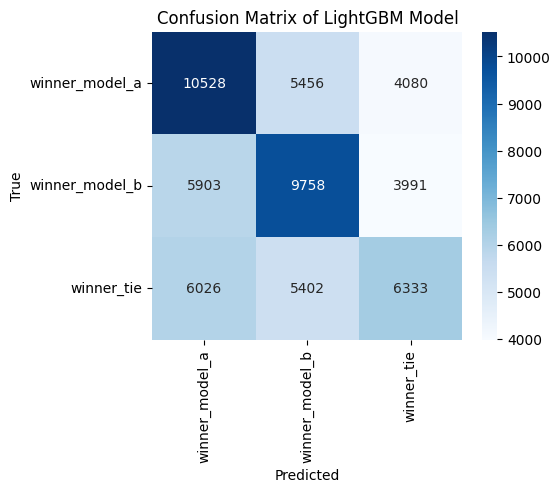

Class winner_model_a LogLoss: 0.9914
Class winner_model_b LogLoss: 1.0113
Class winner_tie LogLoss: 1.1246
                precision    recall  f1-score   support

winner_model_a       0.47      0.52      0.50     20064
winner_model_b       0.47      0.50      0.48     19652
    winner_tie       0.44      0.36      0.39     17761

      accuracy                           0.46     57477
     macro avg       0.46      0.46      0.46     57477
  weighted avg       0.46      0.46      0.46     57477

[True Label] winner_tie | [Predicted] winner_model_b
Prompt: ["explain function calling. how would you call a function?"]...
Response A: ["Function calling is the process of invoking or executing a function in a programming language. To call a function, you need to use the function's name followed by parentheses \"()\". Within the parentheses, you can pass arguments if the function requires any.\n\nHere is an example of how to call a...
Response B: ["Function calling is the process of invoking

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, log_loss, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Use oof3(LightGBM Model)
y_true = y
y_pred = np.argmax(oof3, axis=1)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['winner_model_a', 'winner_model_b', 'winner_tie']

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of LightGBM Model')
plt.show()

# 2. Per-class Log Loss
class_losses = []
for i in range(3):
    mask = (y_true == i)
    loss = log_loss(y_true[mask], oof3[mask], labels=[0,1,2])
    class_losses.append(loss)
    print(f"Class {labels[i]} LogLoss: {loss:.4f}")

# 3. Classification Report
print(classification_report(y_true, y_pred, target_names=labels))

# 4. Qualitative Error Examples
error_idx = np.where(y_true != y_pred)[0][:5]
for i in error_idx:
    print("="*80)
    print(f"[True Label] {labels[y_true[i]]} | [Predicted] {labels[y_pred[i]]}")
    print(f"Prompt: {train_df.iloc[i]['prompt'][:300]}...")
    print(f"Response A: {train_df.iloc[i]['response_a'][:300]}...")
    print(f"Response B: {train_df.iloc[i]['response_b'][:300]}...")

# Step 5. Final Model and Results

In [ ]:
import pandas as pd
import numpy as np

# Load all model submission files
sub1 = pd.read_csv("step_1_submission.csv")
sub3_1 = pd.read_csv("step_3_lgb_submission.csv")
sub3_2 = pd.read_csv("step_3_deberta_lora_submission.csv")

# Weighted ensemble (weighted average)
# LightGBM Model gets high weight because of high performance
w1, w3_1, w3_2 = 0.2, 0.5, 0.3

final_sub = sub1.copy()
for col in ['winner_model_a', 'winner_model_b', 'winner_tie']:
    final_sub[col] = (
        w1 * sub1[col] +
        w3_1 * sub3_1[col] +
        w3_2 * sub3_2[col]
    )

# Normalization
final_sub[['winner_model_a', 'winner_model_b', 'winner_tie']] = \
    final_sub[['winner_model_a', 'winner_model_b', 'winner_tie']].div(
        final_sub[['winner_model_a', 'winner_model_b', 'winner_tie']].sum(axis=1), axis=0
    )

# Save the final ensemble submission
final_sub.to_csv("submission.csv", index=False)
print("Final ensemble file 'submission.csv' created successfully.")
print(final_sub.head())

✅ Final ensemble file 'final_ensemble_submission.csv' created successfully.
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.270791        0.334063    0.395146
1   211333        0.442970        0.264652    0.292378
2  1233961        0.353790        0.347203    0.299007
